In [15]:
from __future__ import print_function
import matplotlib
import os
import pyart
import xarray as xr
import numpy as np
import pyproj as Proj
import act
import wrf
from netCDF4 import num2date, date2num, Dataset
from matplotlib.animation import FuncAnimation, writers
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import RegularGridInterpolator
#import scipy.interpolate.griddata
%matplotlib inline

## Notebook for evaluating radar scan strategies using model data.

## Download EPCAPE radar data using ACT

Use this line to download EPC KaSACR data. The first two strings are your ARM Live username and token. If you do not have those, obtain those at https://adc.arm.gov/armlive/livedata/home.

In [ ]:
act.discovery.download_data('', '', 'epckasacrcfrS2.a1',
                            '2023/06/13T15:49:00', '2023/06/13T17:00:00')

Load both the PPIV radar into *radar* and the RHI into *radar_rhi*.

In [427]:
radar = pyart.io.read('epckasacrcfrS2.a1/epckasacrcfrS2.a1.20230707.063341.nc')

In [262]:
radar_rhi = pyart.io.read('epckasacrcfrS2.a1/epckasacrcfrS2.a1.20230707.064114.nc')

Looking at the 2D composites to see which one of the LASSO timesteps we need. It looks like timestep 20 is a great candidiate.

In [53]:
twod_data = xr.open_dataset('/Users/rjackson/sgp20150829_alpha1r.msda_300km_ls.msda_300km_sf.sonde_init.144_144.2Dcom_1.nc')
twod_data

<xarray.Dataset>
Dimensions:  (time: 90, y: 144, x: 144)
Coordinates:
  * time     (time) float32 241.5 241.5 241.5 241.5 ... 242.1 242.1 242.1 242.1
  * x        (x) float32 0.0 100.0 200.0 300.0 ... 1.41e+04 1.42e+04 1.43e+04
  * y        (y) float32 0.0 100.0 200.0 300.0 ... 1.41e+04 1.42e+04 1.43e+04
Data variables: (12/26)
    CLD      (time, y, x) float32 ...
    CWP      (time, y, x) float32 ...
    IWP      (time, y, x) float32 ...
    LWNS     (time, y, x) float32 ...
    LWNSC    (time, y, x) float32 ...
    LWNT     (time, y, x) float32 ...
    ...       ...
    V200     (time, y, x) float32 ...
    V850     (time, y, x) float32 ...
    VSFC     (time, y, x) float32 ...
    W500     (time, y, x) float32 ...
    ZC       (time, y, x) float32 ...
    ZE       (time, y, x) float32 ...
Attributes: (12/31)
    doi:                                   10.5439/1342961
    contacts:                              lasso@arm.gov, LASSO PI: William G...
    process_version:                       Alpha 2b (Alpha 1 for Alpha 2) Rel...
    site_id:                               sgp
    facility_id:                           C1
    location_description:                  Southern Great Plains (SGP), Lamon...
    ...                                    ...
    config_microphysics:                   Morrison 2-MOM (M2005)
    config_nickname:                       alpha1r.msda_300km_ls.msda_300km_s...
    config_comments:                       Alpha 2 rerun of 2015 (Alpha 1) cases
    simulation_origin_host:                cumulus-login2
    history:                               Fri Mar 30 20:59:20 2018: ncks -O ...
    NCO:                                   "4.6.4"

Looks like a StCu-field here!

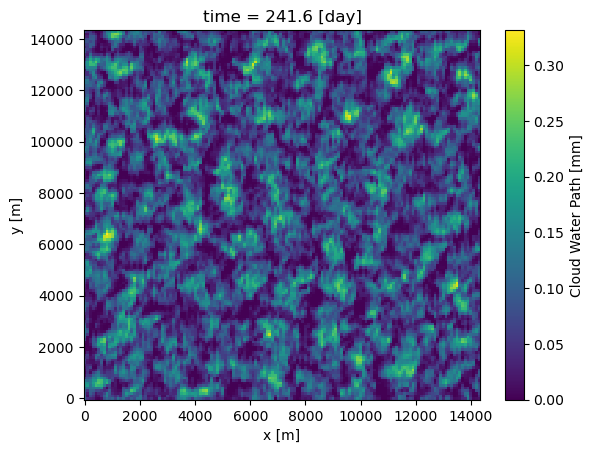

In [80]:
twod_data["CWP"].isel(time=20).plot()

In [68]:
twod_data["time"][15]

<xarray.DataArray 'time' ()>
array(241.61111, dtype=float32)
Coordinates:
    time     float32 241.6
Attributes:
    units:      day
    long_name:  time

Open the full 3D simulation.

In [83]:
wrf_data = xr.open_dataset('sgp20150829_alpha1r.msda_300km_ls.msda_300km_sf.sonde_init.144_144_0000022800.nc')
wrf_data

<xarray.Dataset>
Dimensions:  (time: 1, z: 226, y: 144, x: 144)
Coordinates:
  * time     (time) float32 241.6
  * x        (x) float32 0.0 100.0 200.0 300.0 ... 1.41e+04 1.42e+04 1.43e+04
  * y        (y) float32 0.0 100.0 200.0 300.0 ... 1.41e+04 1.42e+04 1.43e+04
  * z        (z) float32 15.0 45.0 75.0 105.0 ... 1.409e+04 1.439e+04 1.467e+04
Data variables: (12/19)
    NC       (time, z, y, x) float32 ...
    NG       (time, z, y, x) float32 ...
    NI       (time, z, y, x) float32 ...
    NR       (time, z, y, x) float32 ...
    NS       (time, z, y, x) float32 ...
    PP       (time, z, y, x) float32 ...
    ...       ...
    QV       (time, z, y, x) float32 ...
    TABS     (time, z, y, x) float32 ...
    U        (time, z, y, x) float32 ...
    V        (time, z, y, x) float32 ...
    W        (time, z, y, x) float32 ...
    p        (z) float32 ...
Attributes: (12/31)
    doi:                                   10.5439/1342961
    contacts:                              lasso@arm.gov, LASSO PI: William G...
    process_version:                       Alpha 2b (Alpha 1 for Alpha 2) Rel...
    site_id:                               sgp
    facility_id:                           C1
    location_description:                  Southern Great Plains (SGP), Lamon...
    ...                                    ...
    config_microphysics:                   Morrison 2-MOM (M2005)
    config_nickname:                       alpha1r.msda_300km_ls.msda_300km_s...
    config_comments:                       Alpha 2 rerun of 2015 (Alpha 1) cases
    simulation_origin_host:                cumulus-login2
    history:                               Fri Mar 30 21:02:19 2018: ncks -O ...
    NCO:                                   "4.6.4"

Look at the EPC KaSACR data to get the scan strategy for PPIV2. 

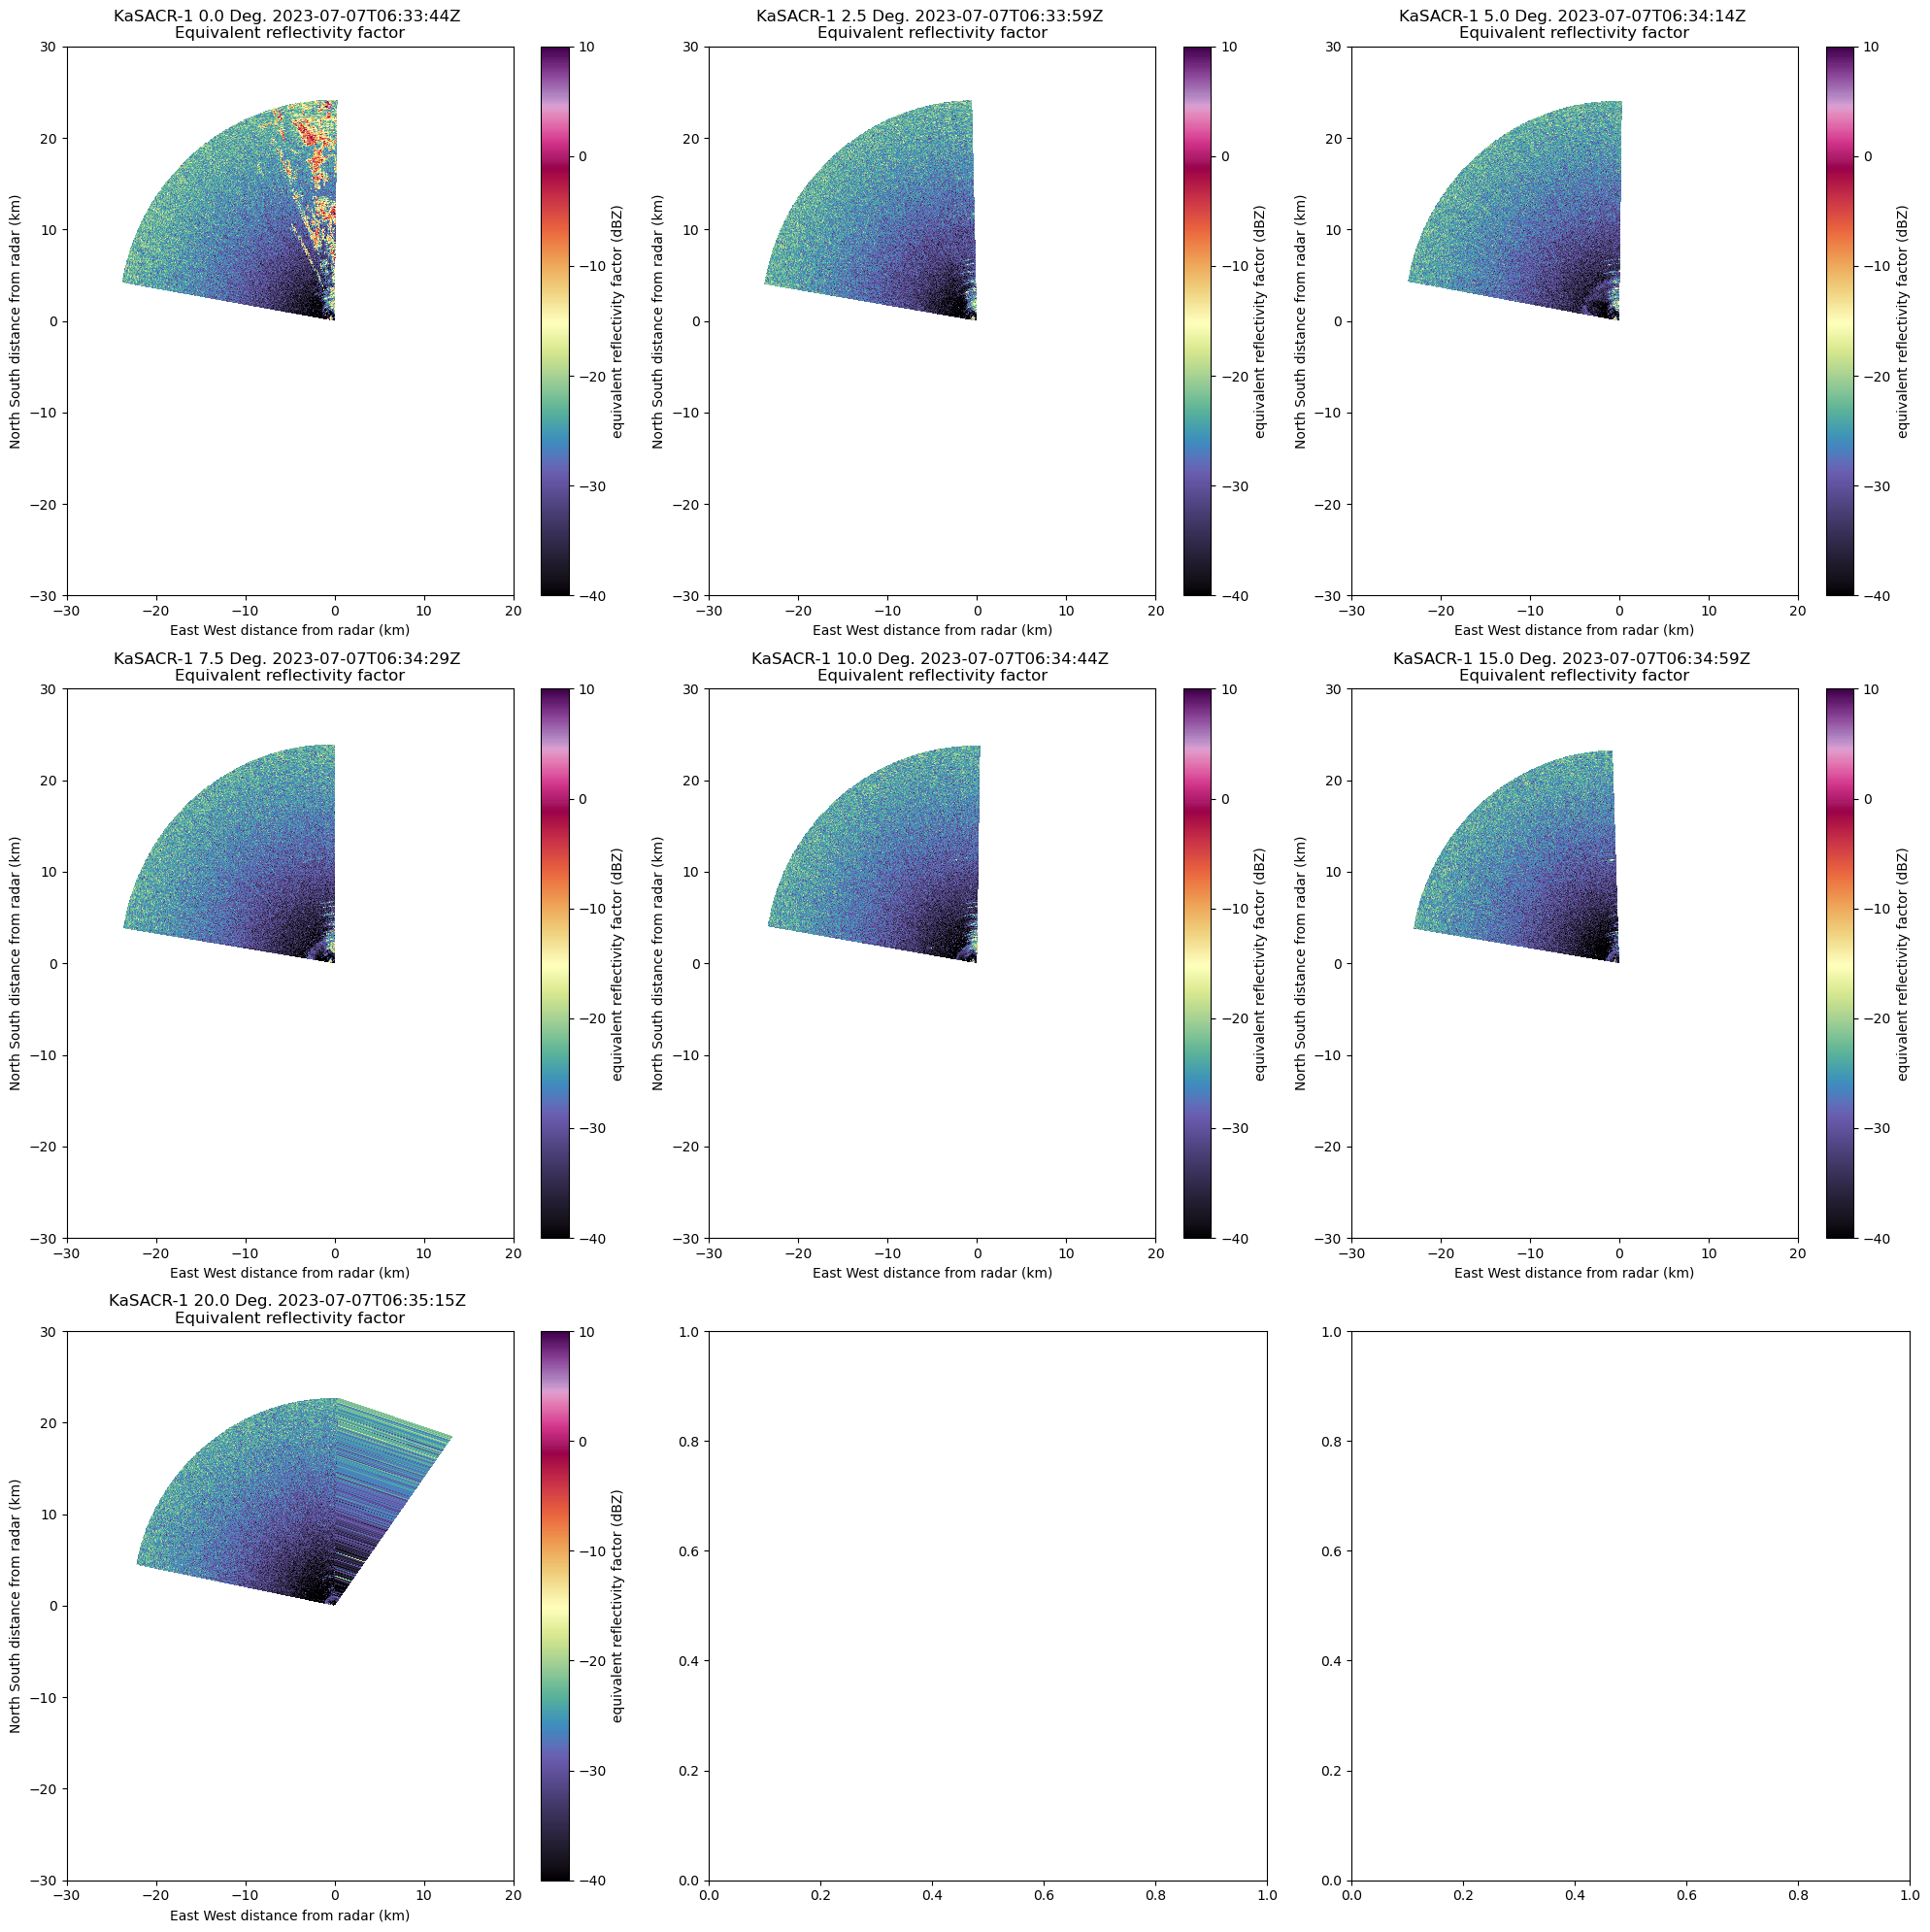

In [428]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for i in range(radar.nsweeps):
    disp = pyart.graph.RadarDisplay(radar)
    disp.plot_ppi('reflectivity', ax=ax[int(i/3), i % 3], sweep=i,
                 cmap='pyart_ChaseSpectral', vmin=-40, vmax=10)
    ax[int(i/3), i % 3].set_xlim([-30, 20])
    ax[int(i/3), i % 3].set_ylim([-30, 30])
fig.tight_layout()

Get the start and end point of the first sweep of the radar to plot the cross section on the grid.

In [265]:
swp0st, swp0end = radar.get_start_end(0)
start_lat = radar.gate_latitude['data'][swp0st:swp0end][0, 0]
end_lat = radar.gate_latitude['data'][swp0st:swp0end][0, -1]
start_lon = radar.gate_longitude['data'][swp0st:swp0end][0, 0]
end_lon = radar.gate_longitude['data'][swp0st:swp0end][0, -1]

What does the RHI look like?

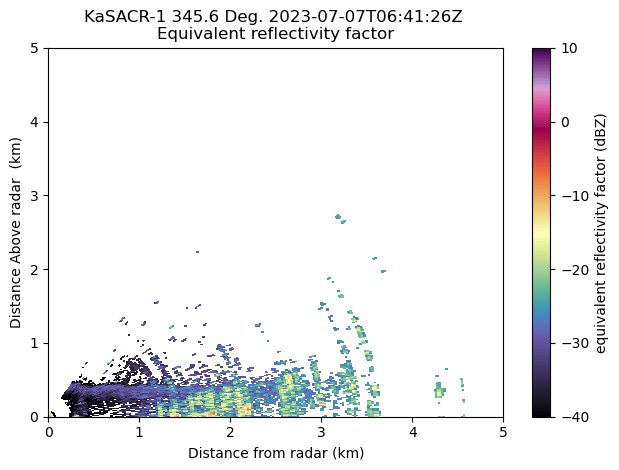

In [279]:
disp = pyart.graph.RadarDisplay(radar_rhi)
gatefilter = pyart.filters.GateFilter(radar_rhi)
gatefilter.exclude_below('signal_to_noise_ratio_copolar_h', 1)
disp.plot_rhi('reflectivity', cmap='pyart_ChaseSpectral', 
              vmin=-40, vmax=10, gatefilter=gatefilter)
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.tight_layout()
plt.savefig('rhi.png', bbox_inches='tight')

## Let's look at the grid for our observations

Here, we grid the PPI data and compare against the RHI above.

In [293]:
grid_spec = (80, 101, 101)
grid_limits = ((0, 10000.), (-10000, 10000), (-10000, 10000))
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_below('signal_to_noise_ratio_copolar_h', 1)
grid = pyart.map.grid_from_radars(
    [radar], grid_shape=grid_spec, grid_limits=grid_limits, gatefilter=gatefilter,
     roi_func='constant_roi', constant_roi=200.)

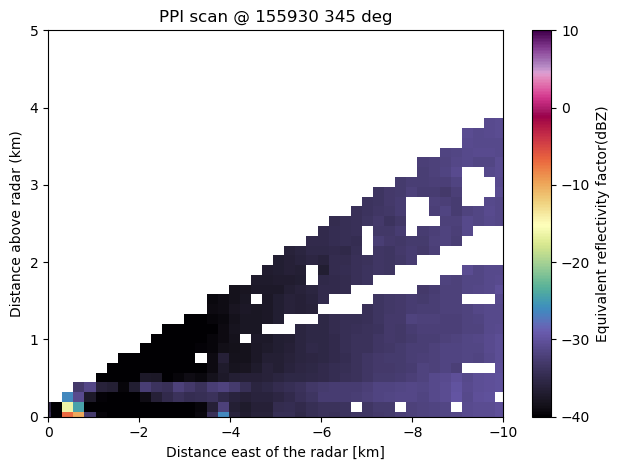

In [294]:
disp = pyart.graph.GridMapDisplay(grid)
disp.plot_cross_section('reflectivity', (start_lat, start_lon), (end_lat, end_lon),
                       vmin=-40, vmax=10, cmap='pyart_ChaseSpectral',
                       x_axis='x') 
plt.xlim([-10, 0])
plt.gca().invert_xaxis()
plt.ylim([0, 5])
plt.xlabel('Distance east of the radar [km]')
plt.title('PPI scan @ 155930 345 deg')
plt.tight_layout()
plt.savefig('ppi.png', bbox_inches='tight')

Load some necessary parameters from the LASSO simulation.

In [403]:
shp = z_array.shape
print(shp, wrf_data['QG'].shape)
qliquid = wrf_data['QN'].values + wrf_data['QP'].values
time = wrf_data.time
x_array = wrf_data['x'].values
y_array = wrf_data['y'].values
z_array = wrf_data['z'].values

(226,) (1, 226, 144, 144)


## Simulation

This LASSO simulation has a StCu-like field at time period 20 as shown by the cloud mixing ratio.

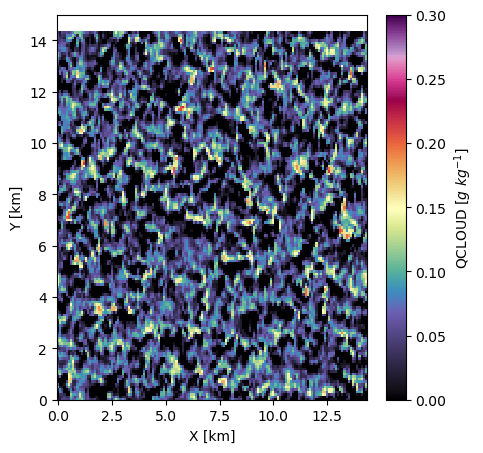

In [140]:
fig = plt.figure(figsize = [5,5])
plt.pcolormesh(x_array/1000.0, y_array/1000.0, 
               qliquid[0, 10, :,:],
              vmin = 0, vmax = 0.3, cmap='pyart_ChaseSpectral')
#plt.scatter(5, -6, marker='x', color='w')
cb = plt.colorbar()
cb.set_label('QCLOUD [$g\ kg^{-1}$]')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.ylim([0, 15])
plt.savefig('QCLOUD.png')

In [284]:
my_interpolating_function = RegularGridInterpolator((z_array, 
                                                     y_array, x_array), 
                                                     qliquid[0,::,:,:],
                                                     bounds_error = False,
                                                     fill_value = radar.fields['reflectivity']['_FillValue'])

## Interpolation

This code will project the liquid cloud mixing ratio and U-wind to the radar's coordinates then re-grid that data back to the model Cartesian grid.

In [447]:
radar_center = (15, 0)
my_interpolating_function = RegularGridInterpolator((z_array, 
                                                     y_array, x_array), 
                                                     qliquid[0,::,:,:],
                                                     bounds_error = False,
                                                     fill_value = radar.fields['reflectivity']['_FillValue'])
rx, ry, rz  = (radar_center[0]*1e3 + radar.gate_x['data'].flatten(), 
              radar_center[1]*1e3 + radar.gate_y['data'].flatten(),
              radar.gate_z['data'].flatten())

que2 = np.array([[rz[i], ry[i], rx[i]] for i in range(len(rz))])
doneme2 = my_interpolating_function(que2)
my_new_field = doneme2.reshape(radar.fields['reflectivity']['data'].shape)
mnf_masked = np.ma.masked_where(my_new_field == radar.fields['reflectivity']['_FillValue'],
                                my_new_field)
qcloud = {'data': mnf_masked, 'units': 'g kg-1',
          'long_name': 'Cloud and rain water mixing ratio'}
radar.add_field('qliquid', qcloud, 
                     replace_existing=True)
U = wrf_data['U'].values[0, :, :, :].squeeze()
my_interpolating_function = RegularGridInterpolator((z_array, 
                                                     y_array, x_array), 
                                                     U,
                                                     bounds_error = False,
                                                     fill_value = radar.fields['reflectivity']['_FillValue'])
rx, ry, rz  = (radar_center[0]*1e3 + radar.gate_x['data'].flatten(), 
              radar_center[1]*1e3 + radar.gate_y['data'].flatten(),
              radar.gate_z['data'].flatten())

que2 = np.array([[rz[i], ry[i], rx[i]] for i in range(len(rz))])
doneme2 = my_interpolating_function(que2)
my_new_field = doneme2.reshape(radar.fields['reflectivity']['data'].shape)
mnf_masked = np.ma.masked_where(my_new_field == radar.fields['reflectivity']['_FillValue'],
                                my_new_field)
qcloud = {'data': mnf_masked, 'units': 'm s-1', 'long_name': 'U component of wind'}
radar.add_field('U', qcloud, replace_existing=True)

Map the PPI scan to the model's coordinates.

In [448]:
grids = pyart.map.grid_from_radars(
         (radar,), grid_shape=(len(z_array), len(y_array), len(x_array)),
        grid_limits=((z_array.min(), z_array.max()),
                     (y_array.min() - radar_center[1] * 1e3, y_array.max() - radar_center[1] * 1e3),
                     (x_array.min() - radar_center[0] * 1e3, x_array.max() - radar_center[0] * 1e3)),
    roi_func='constant_roi', constant_roi=100.)

Let's view some cross sections of Q and V as a sanity check!

In [444]:
x_array.max() - radar_center[0] * 1e3

-700.0

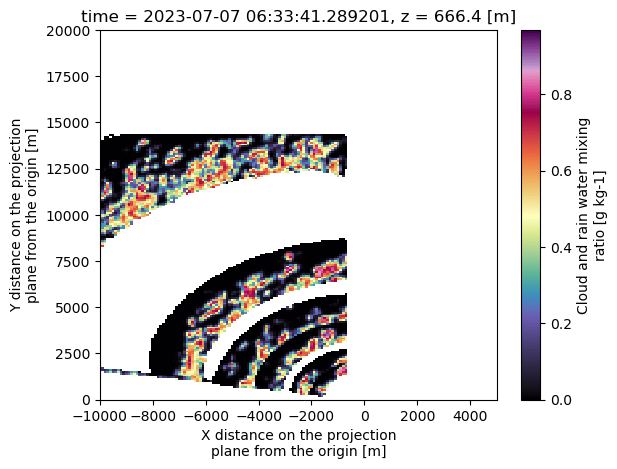

In [500]:
grid_xr = grids.to_xarray()
grid_xr['qliquid'].isel(z=10).plot(cmap='pyart_ChaseSpectral', vmin=0)
plt.xlim([-10000, 5000])
plt.ylim([0, 20000])
plt.savefig('horiz_ppiv_lasso.png', bbox_inches='tight')

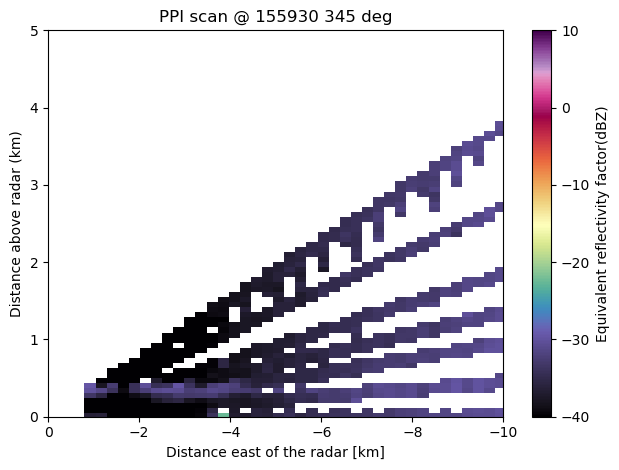

In [501]:
disp = pyart.graph.GridMapDisplay(grids)
disp.plot_cross_section('reflectivity', (start_lat, start_lon), (end_lat, end_lon),
                       vmin=-40, vmax=10, cmap='pyart_ChaseSpectral',
                       x_axis='x') 
plt.xlim([-10, 0])
plt.gca().invert_xaxis()
plt.ylim([0, 5])
plt.xlabel('Distance east of the radar [km]')
plt.title('PPI scan @ 155930 345 deg')
plt.tight_layout()
plt.savefig('ppiv_lasso.png', bbox_inches='tight')

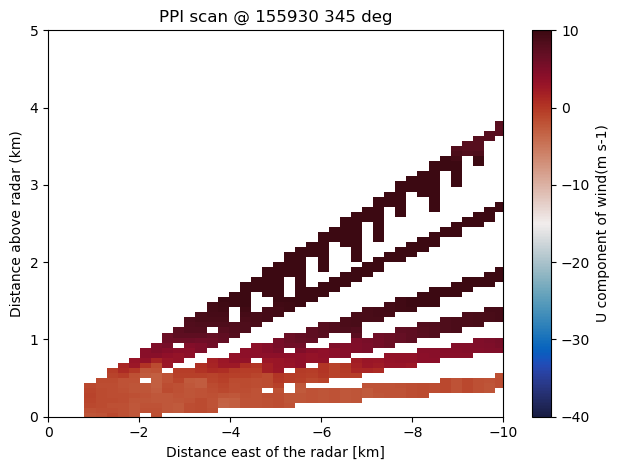

In [502]:
disp = pyart.graph.GridMapDisplay(grids)
disp.plot_cross_section('U', (start_lat, start_lon), (end_lat, end_lon),
                       vmin=-40, vmax=10, cmap='pyart_balance',
                       x_axis='x') 
plt.xlim([-10, 0])
plt.gca().invert_xaxis()
plt.ylim([0, 5])
plt.xlabel('Distance east of the radar [km]')
plt.title('PPI scan @ 155930 345 deg')
plt.tight_layout()
plt.savefig('ppiv_velocity_lasso.png', bbox_inches='tight')

Now do the same with the RHI scan!

In [454]:
U = wrf_data['U'].values[0, :, :, :].squeeze()
my_interpolating_function = RegularGridInterpolator((z_array, 
                                                     y_array, x_array), 
                                                     U,
                                                     bounds_error = False,
                                                     fill_value = radar_rhi.fields['reflectivity']['_FillValue'])
rx, ry, rz  = (radar_center[0]*1e3 + radar_rhi.gate_x['data'].flatten(), 
              radar_center[1]*1e3 + radar_rhi.gate_y['data'].flatten(),
              radar_rhi.gate_z['data'].flatten())

que2 = np.array([[rz[i], ry[i], rx[i]] for i in range(len(rz))])
doneme2 = my_interpolating_function(que2)
my_new_field = doneme2.reshape(radar_rhi.fields['reflectivity']['data'].shape)
mnf_masked = np.ma.masked_where(my_new_field == radar.fields['reflectivity']['_FillValue'],
                                my_new_field)
qcloud = {'data': mnf_masked, 'units': 'g kg-1', 'long_name': 'Cloud and rain water mixing ratio'}
radar_rhi.add_field('U', qcloud, replace_existing=True)

Q = qliquid[0, :, :, :].squeeze()
my_interpolating_function = RegularGridInterpolator((z_array, 
                                                     y_array, x_array), 
                                                     Q,
                                                     bounds_error = False,
                                                     fill_value = radar_rhi.fields['reflectivity']['_FillValue'])
rx, ry, rz  = (radar_center[0]*1e3 + radar_rhi.gate_x['data'].flatten(), 
              radar_center[1]*1e3 + radar_rhi.gate_y['data'].flatten(),
              radar_rhi.gate_z['data'].flatten())

que2 = np.array([[rz[i], ry[i], rx[i]] for i in range(len(rz))])
doneme2 = my_interpolating_function(que2)
my_new_field = doneme2.reshape(radar_rhi.fields['reflectivity']['data'].shape)
mnf_masked = np.ma.masked_where(my_new_field == radar.fields['reflectivity']['_FillValue'],
                                my_new_field)
qcloud = {'data': mnf_masked, 'units': 'g kg-1', 'long_name': 'Cloud and rain water mixing ratio'}
radar_rhi.add_field('qcloud', qcloud, replace_existing=True)

In [463]:
grids_rhi = pyart.map.grid_from_radars(
         (radar_rhi,), grid_shape=(len(z_array), len(y_array), len(x_array)),
        grid_limits=((z_array.min(), z_array.max()),
                     (y_array.min() - radar_center[1] * 1e3, y_array.max()- radar_center[1] * 1e3),
                     (x_array.min() - radar_center[0] * 1e3, x_array.max()- radar_center[0] * 1e3)),
    roi_func='constant_roi', constant_roi=100.)

Again, another sanity check to reassure us we're doing this correctly.

/Users/rjackson/mambaforge/envs/pydda_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


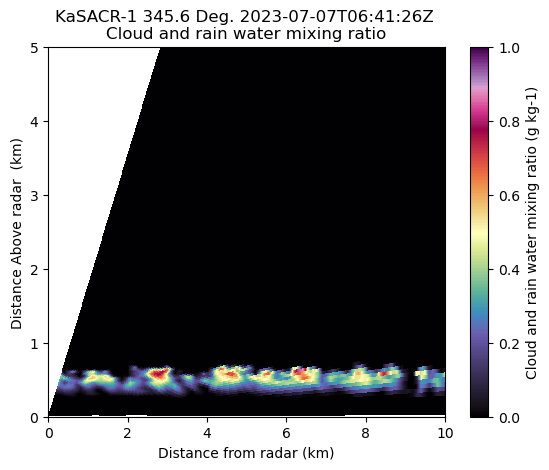

In [503]:
disp = pyart.graph.RadarDisplay(radar_rhi)
disp.plot_rhi('qliquid', vmin=0, vmax=1, cmap='pyart_ChaseSpectral')
plt.ylim([0, 5])
plt.xlim([0, 10])
plt.savefig('lasso_rhi_qcloud.png', bbox_inches='tight')

Let's calculate the mean absolute error between the model and the radar projected fields for each strategy!

In [472]:
ns = []
detail = []

u_error = np.zeros_like(z_array)
q_error = np.zeros_like(z_array)
for i in range(len(z_array)):
    u_error[i] = np.ma.mean(grids.fields['U']['data'][i, :, :] - wrf_data['U'].values[0, i, :, :])
    q_error[i] = np.ma.mean(grids.fields['qliquid']['data'][i, :, :] - qliquid[0, i, :, :])
    
u_error_rhi = np.zeros_like(z_array)
q_error_rhi = np.zeros_like(z_array)
for i in range(len(z_array)):
    u_error_rhi[i] = np.ma.mean(grids_rhi.fields['U']['data'][i, :, :] - wrf_data['U'].values[0, i, :, :])
    q_error_rhi[i] = np.ma.mean(grids_rhi.fields['qliquid']['data'][i, :, :] - qliquid[0, i, :, :])

/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_52708/2669179407.py:7: UserWarning: Warning: converting a masked element to nan.
  u_error[i] = np.ma.mean(grids.fields['U']['data'][i, :, :] - wrf_data['U'].values[0, i, :, :])
/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_52708/2669179407.py:8: UserWarning: Warning: converting a masked element to nan.
  q_error[i] = np.ma.mean(grids.fields['qliquid']['data'][i, :, :] - qliquid[0, i, :, :])


Plot our results.

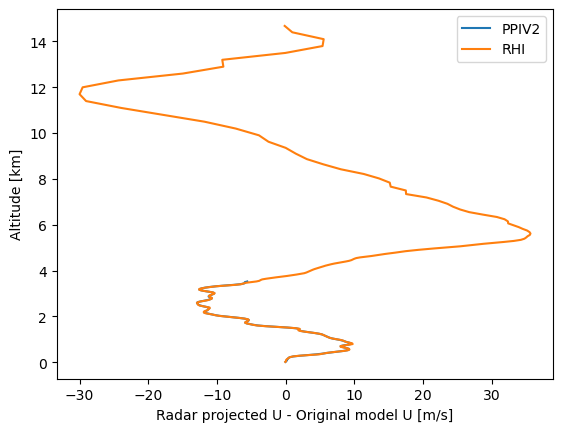

In [504]:
plt.plot(u_error, z_array / 1e3, label='PPIV2')
plt.plot(u_error_rhi, z_array / 1e3, label='RHI')
plt.xlabel('Radar projected U - Original model U [m/s]')
plt.ylabel('Altitude [km]')
plt.legend()
plt.savefig('U_error.png')

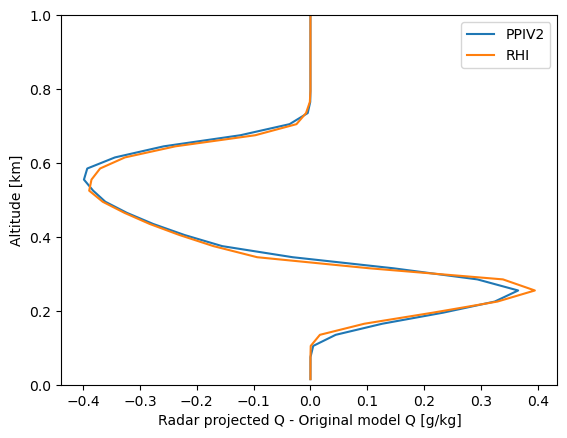

In [505]:
plt.plot(q_error, z_array / 1e3, label='PPIV2')
plt.plot(q_error_rhi, z_array / 1e3, label='RHI')
plt.xlabel('Radar projected Q - Original model Q [g/kg]')
plt.ylabel('Altitude [km]')
plt.legend()
plt.ylim([0, 1])
plt.savefig('Q_error.png')

Looking at cloud fraction.

In [481]:
def cloud_fraction(pyart_grid, var, level):
    cf = np.zeros(pyart_grid.nz)
    for i in range(pyart_grid.nz):
       cf[i] = len(np.where(pyart_grid.fields[var]['data'][i,:,:] > level)[0])/(pyart_grid.nx*pyart_grid.ny)
    return cf
    

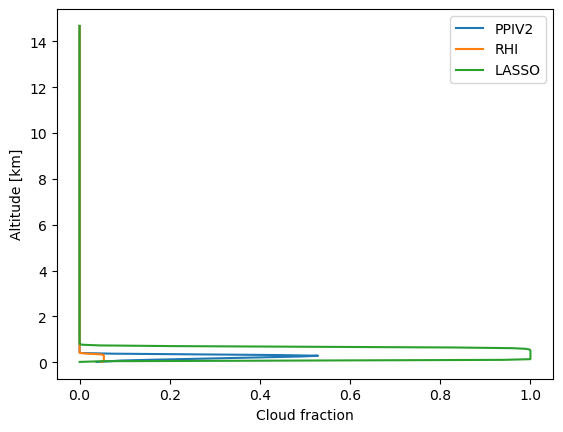

In [486]:
orig = cloud_fraction(grids,'qliquid', 0.0)
orig_rhi = cloud_fraction(grids_rhi, 'qliquid', 0.0)
in_cloud = qliquid > 0
cf_model = in_cloud.sum(axis=2).sum(axis=2) / (in_cloud.shape[2] * in_cloud.shape[3])
plt.plot(orig, z_array / 1e3, label='PPIV2')
plt.plot(orig_rhi, z_array / 1e3, label='RHI')
plt.plot(cf_model.squeeze(), z_array / 1e3, label='LASSO')
plt.xlabel('Cloud fraction')
plt.ylabel('Altitude [km]')
plt.legend()

In [132]:
plt.legend?